# Enceladus Plume particles spectra for orbit no. 279, 286 and 290
In this notebook, we read the plume spectra from calibrated files and apply background removal techniques to improve the signal-to-noise ratio. The same procedure consisting of multiple steps is applied to all three orbits beind studies for this project. Hence, a class is created that can be used for each orbit.

### Class PlumeSpectra has the following functions:
- #### read_savs()
     - This function reads plume spectra that is stored in the form of idlsave files. Each idl file contains a slew of information corresponding to an orbital position in one orbit of Enceladus around Saturn. We are ineterested in three main variables contained in the idl file:
         - s.qrpj contains the I/F value with shape (30, 20, 352) like an image/cube with size 30x20 and 352 spectral channels
         - s.r contains the value of the x-axis of the above image/cube, hence has the size 20
         - s.z conatins the values of the y-axis of the image and has a size of 30
     - This function shows a sample image/cube with x, y value on its axes with a resolution of 100 km each and I/F for one wavelength. The files are calibrated such that Enceladus is centered at (0, 0). For our analysis, we focus on the plume that originates out of Enceladus' South pole. Since Enceladus has a radius of 250 km, the plume begins at s.z or y-axis = -250 km and exists beyond this region. s.defines the x-axis of the image/cube.
     - The I/F values read from the s.qrpj variable are saved as the plume spectra in this function.
     - The no of idlsave files define the number of orbital position in the particular orbit being studied. For instance, 302 idlsave files refer to 302 orbital positions/orbital phases of Enceladus in its orbit around Saturn.
     
- #### read_wavelength()
     - Each cube/image has 352 channels. What is the wavelength of these channels? This function reads values from the file 'wavelength_vims.txt' that contains wavelengths for Cassini VIMS instrument.
     
- #### median_outliers()
     - This is a helped function that helps define outliers by applying a median filter on the plume cubes/images. It taken into input 
        - the array *arr* in which we want to find the outliers
        - *limit* refers to the threshold value beyond which outliers exist
        - *counter* to keep track of how many times we try to find outliers in the array
        - Once we identify the first set of outliers in the array when counter = 1, these outliers are not a part of the array when the next set of outliers are being identified, so the index changes. We need to account to for this change of index. Becaue these outliers will be removed from other arrays too. *index_avg* saves the index of outliers in terms of the original size

- #### find_cube_outliers()
     - This function identifies outlier images/cubes for each spectral channesl using the above helper function. If an image/outlier is considered an outlier for more than 35 spectral channels, we consider that image/cube index as an outlier for all spectral channels. 
     
- #### bin_plume_spectra()
     - Begin by declaring an array the size of the orbital positions and subtracting the outlier indices from it.
     - The relevant orbital positions indices are then converted to multiples of 10 because we want to bin 10 images/cubes each. Let's say for 302 orbital positions/cubes/image, there are 12 outliers. After removing the 12 outliers, we are left with 290 orbital positions/cubes. When we bin 10 cubes each, we eventually have 29 orbital positons. 
     - Save the binned spectra for future analysis
     
- #### integrate_spectra()
     - This function is used to remove background from every single image/cube. The background or noise exists in the shaded region of the below image. We fit a linear line to the data in this region and use the paramaters calculated for this fit to remove background from the area around the plume.
     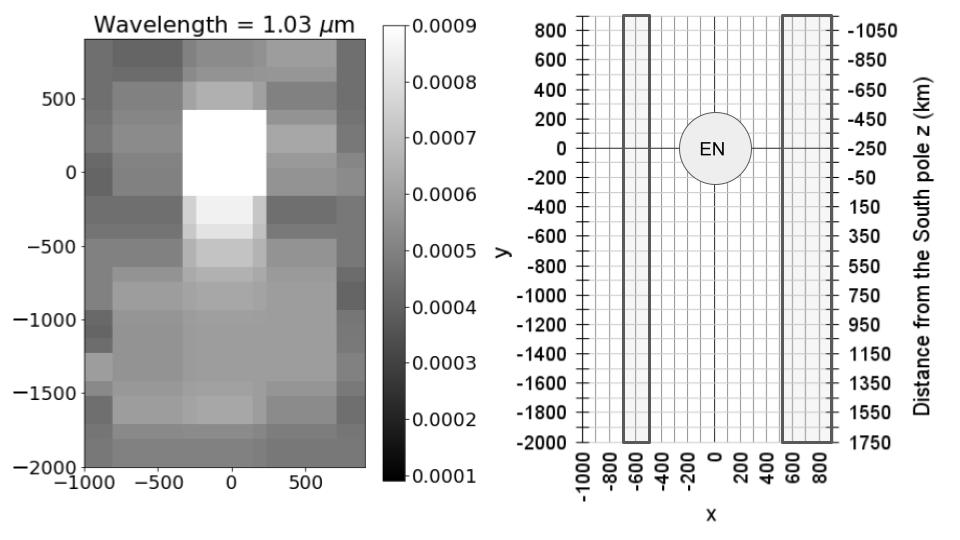
     - A linear fit is applied to the shaded region and these linear fit parameters are used to remove the background from the complete range of r or x-axis 
     - After the background removal, the I/F values are added in the area where x-axis > -700. This sum is multiple by 100 the resolution of axes to calculate what we call Equivalent Width.

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import idlsave
import math
from collections import Counter
from scipy import stats
from uncertainties import ufloat
from uncertainties.umath import * 
plt.rcParams.update({'font.size': 16})
#ignore warnings for this notebook as binning and identifying outliers soemtimes creates error
#In our case it doesn't matter as we are only using it to identify outliers

In [49]:
#Generalized class for all 3 orbits
class PlumeSpectra:
    
    def read_savs(self, folder_name, orbit_folder):
        rDir = f'Enceladus Plume_{folder_name}/calibrated_{orbit_folder}/'
        savs = []
        for fil in os.listdir(rDir):
            if fil.endswith(".erpj"):
                savs.append(os.path.join(rDir,fil))
        #Very important to sort files or you lose the order
        savs.sort()
        
        #Look at an example sav file
        s = idlsave.read(savs[150]) #150th orbital phase
        print("Shape of qrpj or image:", s.qrpj.shape)
        print("z or y-axis (in km):", s.z)
        print("r or x-axis (in km):", s.r)
        print("Shape of y axis of image:", s.z.shape)
        print("Shape of x axis of image:", s.r.shape)
        #These values are same for each file:
        #r or x-axis saved for future use refers to x-axis of image
        self.arr_r = s.r
        #z or y-axis saved for future use refers to y-axis of image
        self.arr_z = s.z
        
        plt.imshow(s.qrpj[:, :, 150][::-1], extent = [-1000, 900, -2000, 900], cmap = 'gray', vmin = 0.00009, vmax = 0.0009, interpolation='none')
        plt.title(f'Orbital Position:150')
        plt.show()

        #save all images/cubes
        self.plume_spec = []
        for i in range(len(savs)):
            s = idlsave.read(savs[i])
            self.plume_spec.append(s.qrpj)
        self.plume_spec = np.array(self.plume_spec)
        print(f"Shape of plume spectra: {self.plume_spec.shape}\nNo of cubes/images = {self.plume_spec.shape[0]}\nNo of altitudes = {self.plume_spec.shape[1]}\nLength of x-axis = {self.plume_spec.shape[2]}\nNo. of wavelengths = {self.plume_spec.shape[3]}")

        
    def read_wavelength(self):
        with open('wavelength_vims.txt', 'r') as f:
            lines = f.readlines()
        self.plume_wave = np.array([float(line.split()[1]) for line in lines])
        print(f"\nSize of wavelength array: {self.plume_wave.shape}\n")
    
    
    def median_outliers(self, arr, limit, counter, index_avg = 0):
        arr_med = np.nanmedian(arr)
        arr_std = np.nanstd(arr)
        #print("Arr:", arr)
        #print("arr_med:", arr_med)
        #print("arr_std:", arr_std)
        difference_std = (arr - arr_med)/arr_std #median outliers
        if counter == 0: #first outliers are straightforward because there are no indexing issues.
            return np.where( (difference_std > limit) | (difference_std < (-1*limit)) | (np.isnan(arr)) )[0], arr_med, arr_std
        else: # for all other steps limit is 3.0
            first_res = np.where( (difference_std > limit) | (difference_std < (-1*limit)) | (np.isnan(arr)) )[0] #first identify outliers
            #print("first_res", first_res) #what is the first result
            outlier_from_index = index_avg[first_res] #pick outliers from indices at which values are averaged
            #print("outlier_from_index", outlier_from_index)
            return outlier_from_index, arr_med, arr_std
        
    
    def find_cube_outliers(self, folder_name):
        #Slice the plume spectra to altitude, and x-axis, and relevant wavelengths
        plume_rel = self.plume_spec[:, 10:18, 6:15, :].copy() #slice relevant plume spectra
        outliers = [] #to save outliers for each spectral channel
        #For each wavelength save average of image
        for w in range( plume_rel.shape[3] ):
            #print("wavelength channel:", w)
            wave_outliers = []
            counter = 0
            while len(wave_outliers) >= 0:
                #empty list to save average for each orbital phase
                plume_wave_avg = []
                #empty list to save indices that are being averaged
                index_avg = []
                #For each orbital phase/position
                for o in range( plume_rel.shape[0]):
                    if o in wave_outliers:
                        continue
                    #save i/f value in a separate array
                    inten = plume_rel[o, :, :, w].copy().reshape(-1)

                    #drop infinite values
                    #First identify the index of infinite values
                    indices = np.argwhere( (np.isnan( inten )) | (np.isinf( inten )) )
                    if indices.size > 0:
                        #print("orbital phase number:", o)
                        #print("inten before:", inten)
                        #print("shape before:", inten.shape)
                        #print("indices", indices)
                        inten = np.delete(inten, indices.reshape(-1))
                        #print("inten after:", inten)

                    #Average of brightness at one wavelength and one orbital phase
                    plume_wave_avg.append(np.mean( inten ))
                    
                    #save indices that are being averaged
                    index_avg.append(o)
                #For each wavelength find which counter you are at:
                if counter == 0: 
                    outliers_one, arr_med, arr_std = self.median_outliers( np.array(plume_wave_avg), 3.0, counter)
                else:
                    outliers_one, arr_med, arr_std = self.median_outliers( np.array(plume_wave_avg), 3.0, counter, np.array(index_avg))
                #print("counter:", counter)
                #print("outliers_one:", outliers_one)
                if len(outliers_one) == 0:
                    break
                wave_outliers.extend(outliers_one)
                counter += 1
            #print("outliers in spectra:", wave_outliers)
            outliers.append(wave_outliers)
        #plot outliers indices
        fig, ax = plt.subplots()
        for i in range(len(outliers)):
            plt.scatter(np.repeat(self.plume_wave[i], len(outliers[i])), outliers[i])
        plt.xlabel("Wavelength (in micron)")
        plt.ylabel("Index of outlier images/cubes")
        plt.show()
        
        #First remove spectral channels where the filter is saturated which are 118, 330
        self.channels = [118, 330]
        print(f"Spectra channels that contains too many outliers = {self.channels} and wavelength = {self.plume_wave[self.channels]} micron\n")

        #Now we have a set of outlier images/cubes for each wavelength channel            
        #Cubes/images outliers across more than 35 spectral channels are reasonable outliers for all channels
        flatten_outliers = [out for sub_list in outliers for out in sub_list]
        count_dict = Counter(flatten_outliers) #count how many times each index appears
        self.outlier_cube_indices = sorted([key for key, value in count_dict.items() if value > 35])
        print(f"Index of cubes/images that exist as outliers in more than 35 spectral channels: {self.outlier_cube_indices}")
        np.savetxt(f'Enceladus Plume_{folder_name}/outlier_cube_indices_{folder_name}.txt', self.outlier_cube_indices)
       
    
    def bin_plume_spectra(self, folder_name):
        #Save the indices of images that get binned
        #Remove outliers indices from a list of indices from 0 to no or orbital phases
        relevant_cubes_indices = np.setdiff1d( np.arange(0, self.plume_spec.shape[0]), self.outlier_cube_indices)
        
        #remove outlier images/cubes
        plume_spec_without_outliers = np.delete(self.plume_spec, self.outlier_cube_indices, axis = 0)
        print("Shape of plume spectra after removing outliers:", plume_spec_without_outliers.shape)
        
        #First check if the number of rest of images/cubes are a multiple of 10
        n_orb = plume_spec_without_outliers.shape[0] #no. of orbital phases
        rem = n_orb % 10
        if rem != 0:
            #slice spectra to multiples of 10
            plume_spec_without_outliers = plume_spec_without_outliers[:(n_orb-rem), :, :, :]
        
        #Reshape spectra to calculate averages of 10 cubes/images
        shape_0, shape_1, shape_2, shape_3 = plume_spec_without_outliers.shape
        plume_spectra_reshaped = plume_spec_without_outliers.reshape(shape_0//10, 10, shape_1, shape_2, shape_3)
        print("Shape of plume spectra after reshaping it into multiples of 10:", plume_spectra_reshaped.shape)
        
        #Reshape list of indices into multiple of 10 too
        relevant_cubes_indices_multiples_10 = relevant_cubes_indices[:(n_orb-rem)].reshape( (n_orb-rem)//10, 10 )
        #print('index:', relevant_cubes_indices_multiples_10)
        np.savetxt(f'Enceladus Plume_{folder_name}/images_binned_indices_{folder_name}.txt', relevant_cubes_indices_multiples_10, fmt = '%i')
        
        #Average 10 cubes each 
        self.binned_plume_spectra = np.mean(plume_spectra_reshaped, axis = 1)
        print(f"Shape of binned plume spectra: {self.binned_plume_spectra.shape}\nNo of binned orbital phases = {self.binned_plume_spectra.shape[0]}\nz or y-axis = {self.binned_plume_spectra.shape[1]}\nr or x-axis = {self.binned_plume_spectra.shape[2]}\nNo. of wavelength channels = {self.binned_plume_spectra.shape[3]}")
        
        #Look at an example binned cube/image
        #10th binned orbital phase and 100th wavelength channel
        plt.imshow(self.binned_plume_spectra[10, :, :, 100][::-1], extent = [-1000, 900, -2000, 900], cmap = 'gray', vmin = 0.00009, vmax = 0.0009, interpolation='none')
        plt.title(f'Orbital Position: 10')
        plt.show()
        
        #Chnage shape of plume spectra such that waveelength comes first; replace wavelength with orbital phase
        self.binned_plume_spectra = np.moveaxis(self.binned_plume_spectra, 3, 0) #source = 3 destination = 0
        print(f"Shape of binned plume spectra after reshaping: {self.binned_plume_spectra.shape}\nNo of wavelengths = {self.binned_plume_spectra.shape[0]}\nNo of binned orbital phases:{self.binned_plume_spectra.shape[1]}\nz or y-axis = {self.binned_plume_spectra.shape[2]}\nr or x-axis = {self.binned_plume_spectra.shape[3]}")

        
    def integrate_spectra(self, folder_name):
        
        #slice area of cube that contains background
        pos1 = np.argwhere(self.arr_r == -700)[0, 0]
        pos2 = np.argwhere(self.arr_r == -500)[0, 0]
        pos3 = np.argwhere(self.arr_r == 500)[0, 0]
        
        inten_before = [] #intensity before the background filter across r (253, no of orbital phases, 30 altitudes, 17 r or x-axis)
        inten_before_alt = [] #intensity after background filter (253, no of orbital phases, no of altitudes)
        inten_after = [] #intensity after the background filter across r (253, no of orbital phases, 30 altitudes, 17 r or x-axis)
        inten_after_alt = [] #equivalent width after background filter (253, no of orbital phases, no of altitudes)
                
        #For each wavelength
        for wave in range( 97, self.binned_plume_spectra.shape[0] ):
            #print("Wavelength:", self.plume_wave[wave])
            if wave in self.channels:
                #print(self.plume_wave[wave])
                continue
                
            #For each orbital phase
            for orb in range( self.binned_plume_spectra.shape[1] ):
                #print("orbital phase number:", orb)
                
                #for plot of I/F across z save across altitude
                intent_before_alt_plot = []
                intent_after_alt_plot = []
                intent_after_alt_err_plot = []
                
                #For each altitude
                for alt in range( self.binned_plume_spectra.shape[2] ):
                    #print("Altitude number:", alt)
                    #intensity across r
                    inten = self.binned_plume_spectra[wave, orb, alt]
                    #save r or x-axis
                    r = self.arr_r.copy()
                    
                    indices = np.argwhere( (np.isnan( inten )) | (np.isinf( inten )) )
                    if indices.size > 0:
                        #print("inten before:", inten)
                        inten = np.delete(inten, indices.reshape(-1))
                        r = np.delete(r, indices.reshape(-1))
                        #print("inten after:", inten)

                    #save values
                    inten_before.append(inten[pos1:])
                    inten_before_alt.append(np.sum(inten[pos1:])*100)
                    
                    #save one value to plot
                    if wave == 100 and orb == 10:
                        intent_before_alt_plot.append(np.sum(inten[pos1:])*100)
                    
                    #first slice
                    y_1 = inten[pos1:pos2]
                    #second slice
                    y_2 = inten[pos3:]
                    #complete slice
                    y = np.concatenate( (y_1, y_2) )
                    
                    #For x-axis values
                    #first slice
                    x_1 = r[pos1:pos2]
                    #second slice
                    x_2 = r[pos3:]
                    #complete slice
                    x = np.concatenate( (x_1, x_2) )
                    
                    #linear fit
                    res = stats.linregress(x, y)
                    #save linear fit parameters
                    slope = ufloat( res.slope, abs(res.stderr) )
                    intercept = ufloat( res.intercept, abs(res.intercept_stderr) )

                    #subtract background from complete intensity range
                    residual = inten - (slope * r + intercept)
                    residual_value, residual_error = np.array([res.nominal_value for res in residual]), np.array([res.std_dev for res in residual])
                    
                    #plot an example for before and after filter
                    if wave == 100 and orb == 10 and alt == 10:
                        fig, axes = plt.subplots(1, 2, figsize = (10, 4))
                        axes[0].plot(self.arr_r, inten, label = 'Original', marker = 'o')
                        axes[0].legend()
                        axes[1].errorbar(self.arr_r, residual_value, residual_error, label = "After filter", marker = 'o')
                        axes[1].legend()
                        axes[0].set_xlabel('r or x-axis')
                        axes[1].set_xlabel('r or x-axis')
                        axes[0].set_ylabel('I/F')
                        plt.suptitle('I/F across r or x-axis before and after background removal', y = 1.0)
                        plt.show()
                    #save after background removal
                    inten_after.append(residual[pos1:])
                    inten_after_alt.append(np.sum(residual[pos1:])*100)
                    
                    #save one value to plot
                    if wave == 100 and orb == 10:
                        intent_after_alt_plot.append(np.sum(residual_value[pos1:])*100)
                        intent_after_alt_err_plot.append(np.sum(residual_error[pos1:])*100)
                        
                #print("inten_after_alt", inten_after_alt)
                    
                #plot example of equivalent width
                if wave == 100 and orb == 10:
                    print("intent_after_alt_plot:", intent_after_alt_plot)
                    fig, axes = plt.subplots(1, 2, figsize = (10, 4))
                    axes[0].plot(self.arr_z, intent_before_alt_plot, label = 'Original', marker = 'o')
                    axes[0].legend()
                    axes[1].errorbar(self.arr_z, intent_after_alt_plot, intent_after_alt_err_plot, label = "After filter", marker = 'o')
                    axes[1].legend()
                    axes[0].set_xlabel('z or y-axis')
                    axes[1].set_xlabel('z or y-axis')
                    axes[0].set_ylabel('I/F')
                    plt.suptitle('Equivalent Width across z or y-axis before and after background removal', y = 1.0)
                    plt.show()   
                    
                    '''arr_img = np.array(intent_before_alt_plot).reshape(30, 1)
                    #Look at an example integrated cube
                    fig, ax = plt.subplots()
                    pos = ax.imshow(arr_img, extent = [0, 5, -2000, 900], cmap = 'gray', vmin = 0.1, vmax = 3.0, interpolation='none')
                    plt.colorbar(pos, ax = ax)
                    plt.title(f'Orbital Position: 10, Wavelength channel: 100')
                    plt.show()'''
                    
                    
        #n_wave is the number of wavelengths = 352 - 97 initial channels - 2 outlier channels
        np.savetxt(f'Enceladus Plume_{folder_name}/inten_before_alt_{folder_name}.txt', inten_before_alt) # n_wave, n_orb, n_alt
        np.savetxt(f'Enceladus Plume_{folder_name}/inten_after_alt_{folder_name}.txt', inten_after_alt, fmt = '%s') #n_wave, n_orb, n_alt


In [50]:
folder_name = [279, 286, 290]
orbit_folder = ['S100_279', 'S101_286', 'S101_290']

--------------------------------------------------
Date: Tue Mar  8 13:01:21 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
Shape of qrpj or image: (30, 20, 352)
z or y-axis (in km): [-2000. -1900. -1800. -1700. -1600. -1500. -1400. -1300. -1200. -1100.
 -1

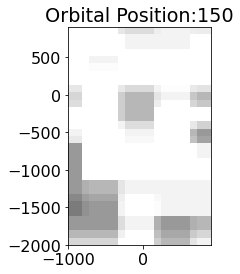

--------------------------------------------------
Date: Tue Mar  8 12:51:36 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:51:39 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:52:18 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:52:22 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:52:57 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:53:01 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:53:44 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:53:48 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:54:34 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:54:38 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:55:17 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:55:21 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:56:04 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:56:08 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:56:47 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:56:50 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:57:33 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:57:37 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:58:32 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:58:36 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 12:59:23 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 12:59:27 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:00:22 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:00:26 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:01:01 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:01:05 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:02:05 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:02:09 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:02:52 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:02:56 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:03:36 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:03:40 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:04:36 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:04:40 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:05:32 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:05:36 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:06:24 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:06:28 2022
User: himz
Host: sordes
---------------------------

Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:07:17 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 

--------------------------------------------------
Date: Tue Mar  8 13:07:57 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:08:01 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:08:53 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:08:57 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:09:42 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:09:46 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:10:34 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:10:38 2022
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Tue Mar  8 13:11:14 2022
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type VERSION
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Mar  8 13:11:18 2022
User: himz
Host: sordes
---------------------------

/home/himanshi/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/himanshi/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/himanshi/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1739: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


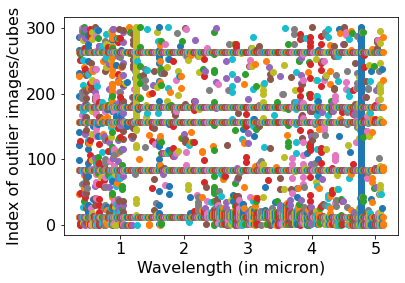

Spectra channels that contains too many outliers = [118, 330] and wavelength = [1.24492 4.77031] micron

Index of cubes/images that exist as outliers in more than 35 spectral channels: [0, 1, 2, 3, 12, 17, 18, 19, 83, 156, 179, 263]
Shape of plume spectra after removing outliers: (290, 30, 20, 352)
Shape of plume spectra after reshaping it into multiples of 10: (29, 10, 30, 20, 352)
Shape of binned plume spectra: (29, 30, 20, 352)
No of binned orbital phases = 29
z or y-axis = 30
r or x-axis = 20
No. of wavelength channels = 352


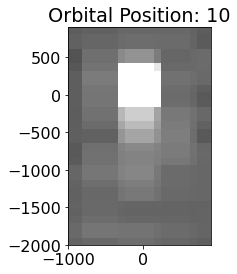

Shape of binned plume spectra after reshaping: (352, 29, 30, 20)
No of wavelengths = 352
No of binned orbital phases:29
z or y-axis = 30
r or x-axis = 20


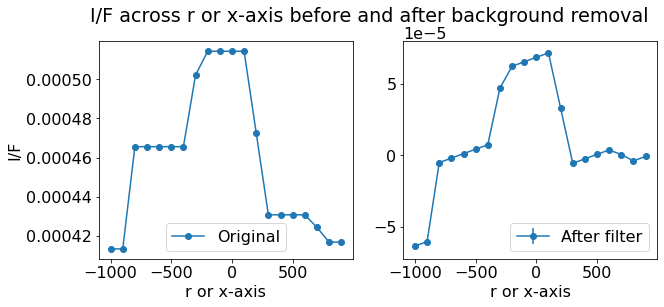

intent_after_alt_plot: [0.01593576240770869, 0.006606789810754683, 0.0066067686473225, -0.0032321898148199076, -0.006514643859969343, -0.0032441361840588223, 0.027939492704785105, 0.027939517771971865, 0.030745446063100357, 0.03520314828949737, 0.035203062309518925, 0.03674818391615549, 0.03677365013292144, 0.0477695844053531, 0.11504322651041195, 0.11504322573018738, 0.137344554723293, 0.15827619216931824, 0.15827620381085042, 0.5556765439357356, 0.6124481679645791, 0.7045282448033522, 0.9807684633669685, 0.980768406961851, 0.4068709151016231, 0.06253242675041674, 0.0625324178008576, 0.018590846607145984, 0.018590831328292857, 0.01233180020422278]


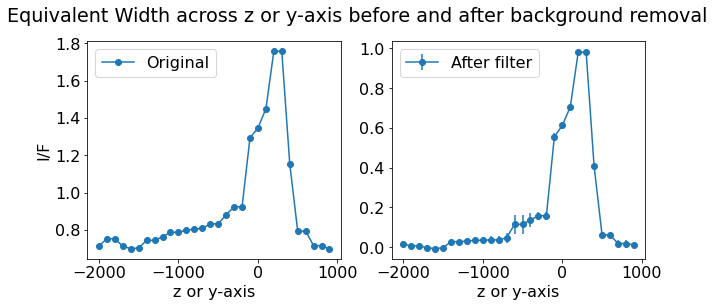

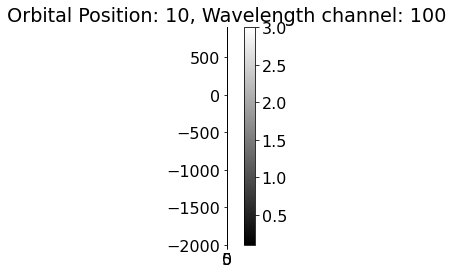

KeyboardInterrupt: 

In [51]:
spectra_279 = PlumeSpectra()
spectra_279.read_savs(folder_name[0], orbit_folder[0])
spectra_279.read_wavelength()
spectra_279.find_cube_outliers(folder_name[0])
spectra_279.bin_plume_spectra(folder_name[0])
spectra_279.integrate_spectra(folder_name[0])

--------------------------------------------------
Date: Mon Apr  6 05:43:22 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
Shape of qrpj or image: (30, 20, 352)
x or y-axis (in km): [-2000. -1900. -1800. -1700. -1600. -1500. -1400. -1300. -1200. -1100.
 -1

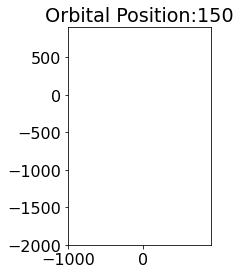

--------------------------------------------------
Date: Mon Apr  6 05:34:54 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:34:58 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:35:34 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:35:38 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:37:08 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:37:12 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:37:55 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:37:59 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:39:43 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:39:47 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:40:34 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:40:38 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:42:48 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:42:51 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:43:36 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:43:40 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:45:45 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:45:49 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:46:31 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:46:34 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:48:17 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:48:21 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:49:03 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:49:07 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:50:54 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:50:57 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 05:51:37 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 05:51:40 2020
User: himz
Host: sordes
---------------------------

/home/himanshi/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/himanshi/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/himanshi/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1739: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


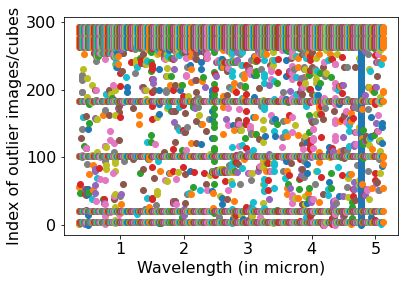

Spectra channels that contains too many outliers = [118, 330] and wavelength = [1.24492 4.77031] micron

Index of cubes/images that exist as outliers in more than 35 spectral channels: [4, 20, 102, 183, 254, 263, 267, 268, 269, 270, 272, 273, 274, 275, 276, 284, 285, 288, 289, 290, 291, 292]
Shape of plume spectra after removing outliers: (271, 30, 20, 352)
Shape of plume spectra after reshaping it into multiples of 10: (27, 10, 30, 20, 352)
Shape of binned plume spectra: (27, 30, 20, 352)
No of binned orbital phases = 27
z or y-axis = 30
r or x-axis = 20
No. of wavelength channels = 352


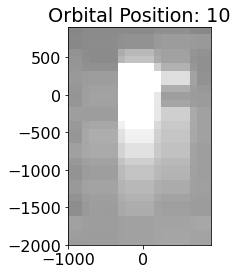

Shape of binned plume spectra after reshaping: (352, 27, 30, 20)
No of wavelengths = 352
No of binned orbital phases:27
z or y-axis = 30
r or x-axis = 20


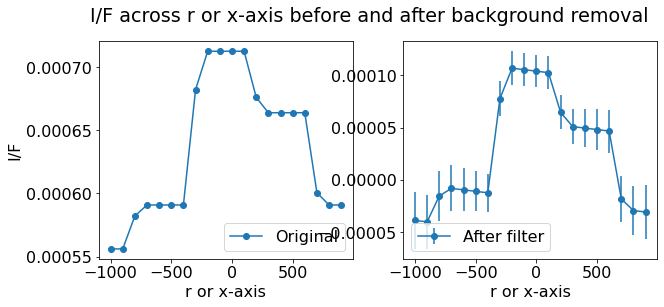

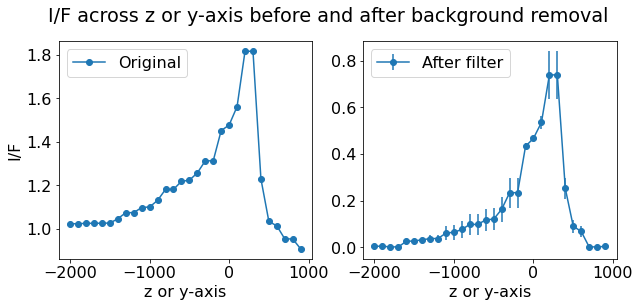

In [7]:
spectra_286 = PlumeSpectra()
spectra_286.read_savs(folder_name[1], orbit_folder[1])
spectra_286.read_wavelength()
spectra_286.find_cube_outliers(folder_name[1])
spectra_286.bin_plume_spectra(folder_name[1])
spectra_286.integrate_spectra(folder_name[1])
#Sampled over altitudes and averaged over pixels

--------------------------------------------------
Date: Mon Apr  6 06:19:19 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
Shape of qrpj or image: (30, 20, 352)
x or y-axis (in km): [-2000. -1900. -1800. -1700. -1600. -1500. -1400. -1300. -1200. -1100.
 -1

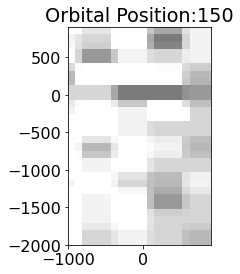

--------------------------------------------------
Date: Mon Apr  6 06:07:06 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:07:10 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:08:04 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:08:09 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:10:44 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:10:48 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:11:37 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:11:42 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:14:02 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:14:07 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:14:56 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:15:01 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:18:14 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:18:19 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:19:09 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:19:14 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:21:54 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:21:59 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:22:54 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:22:59 2020
User: himz
Host: sordes
---------------------------

--------------------------------------------------
Date: Mon Apr  6 06:26:20 2020
User: himz
Host: sordes
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - file [<class 'bytes'>]
 - qrpj [<class 'numpy.ndarray'>]
 - qrpjw [<class 'numpy.ndarray'>]
 - z [<class 'numpy.ndarray'>]
 - r [<class 'numpy.ndarray'>]
 - ph [<class 'numpy.ndarray'>]
 - zr [<class 'numpy.ndarray'>]
 - rr [<class 'numpy.ndarray'>]
 - dz [<class 'numpy.int16'>]
 - dr [<class 'numpy.int16'>]
 - rb [<class 'numpy.int16'>]
--------------------------------------------------
--------------------------------------------------
Date: Mon Apr  6 06:26:25 2020
User: himz
Host: sordes
---------------------------

/home/himanshi/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/himanshi/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/himanshi/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/himanshi/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/himanshi/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


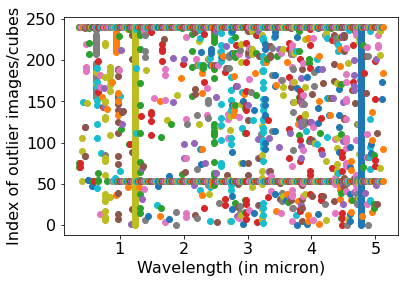

Spectra channels that contains too many outliers = [118, 330] and wavelength = [1.24492 4.77031] micron

Index of cubes/images that exist as outliers in more than 35 spectral channels: [53, 240]
Shape of plume spectra after removing outliers: (239, 30, 20, 352)
Shape of plume spectra after reshaping it into multiples of 10: (23, 10, 30, 20, 352)
Shape of binned plume spectra: (23, 30, 20, 352)
No of binned orbital phases = 23
z or y-axis = 30
r or x-axis = 20
No. of wavelength channels = 352


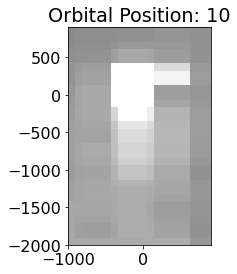

Shape of binned plume spectra after reshaping: (352, 23, 30, 20)
No of wavelengths = 352
No of binned orbital phases:23
z or y-axis = 30
r or x-axis = 20


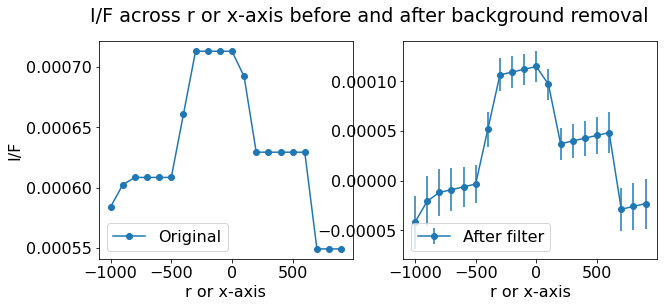

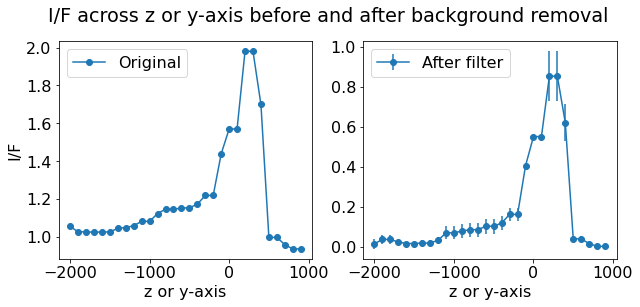

In [8]:
spectra_290 = PlumeSpectra()
spectra_290.read_savs(folder_name[2], orbit_folder[2])
spectra_290.read_wavelength()
spectra_290.find_cube_outliers(folder_name[2])
spectra_290.bin_plume_spectra(folder_name[2])
spectra_290.integrate_spectra(folder_name[2])


## List of files saved in the notebook
- Enceladus Plume_279
  - outlier_cube_indices_279.txt saves the index of outliers cubes/images in orbit no 279
  - images_binned_indices_279.txt saves the index of images/cubes that have been averaged/binned together in multiple of 10 each. For example first 10 cubes that are binned together have indices [4, 5, 6, ...] of size 10
  - inten_before_alt_279.txt plume spectra intensity across altitude before background removal in the shape of 240 spectral channels, 29 orbital phases, 30 altitudes. Values are stored with their respective standard deviation.
  - inten_after_alt_279.txt plume spectra intensity across altitude after background removal in the shape of 240 spectral channels, 29 orbital phases, 30 altitudes. Values are stored with their respective standard deviation.
- Enceladus Plume_286
  - outlier_cube_indices_286.txt saves the index of outliers cubes/images in orbit no 286
  - images_binned_indices_286.txt saves the index of images/cubes that have been averaged/binned together in multiple of 10 each. For example first 10 cubes that are binned together have indices [4, 5, 6, ...] of size 10
   - inten_before_alt_286.txt plume spectra intensity across altitude before background removal in the shape of 240 spectral channels, 27 orbital phases, 30 altitudes. Values are stored with their respective standard deviation.
  - inten_after_alt_286.txt plume spectra intensity across altitude after background removal in the shape of 240 spectra
- Enceladus Plume_290
  - outlier_cube_indices_290.txt saves the index of outliers cubes/images in orbit no 290
  - images_binned_indices_290.txt saves the index of images/cubes that have been averaged/binned together in multiple of 10 each. For example first 10 cubes that are binned together have indices [4, 5, 6, ...] of size 10
   - inten_before_alt_290.txt plume spectra intensity across altitude before background removal in the shape of 240 spectral channels, 23 orbital phases, 30 altitudes. Values are stored with their respective standard deviation.
  - inten_after_alt_290.txt plume spectra intensity across altitude after background removal in the shape of 240 spectra